In [ ]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix
from sklearn.model_selection import learning_curve
# set up notebook to show all outputs in a cell, not only last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import numpy as np

First Goal:

-derive actionable insights for hosts and potential renters

-predict rental prices based on relevant features

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install kaggle
import os

In [ ]:
url = '/content/drive/MyDrive/kaggle/AB_NYC_2019.csv'
df = pd.read_csv(url)

# Inspecting data

In [ ]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
df.shape

(48895, 16)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [ ]:
df['last_review']=pd.to_datetime(df['last_review'])
df.info()
df['last_review'].head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              48895 non-null  int64         
 1   name                            48879 non-null  object        
 2   host_id                         48895 non-null  int64         
 3   host_name                       48874 non-null  object        
 4   neighbourhood_group             48895 non-null  object        
 5   neighbourhood                   48895 non-null  object        
 6   latitude                        48895 non-null  float64       
 7   longitude                       48895 non-null  float64       
 8   room_type                       48895 non-null  object        
 9   price                           48895 non-null  int64         
 10  minimum_nights                  48895 non-null  int64         
 11  nu

0   2018-10-19
1   2019-05-21
2          NaT
3   2019-07-05
4   2018-11-19
Name: last_review, dtype: datetime64[ns]

We'll now inspect (and possibly clean/filter) the data

Things we need to do include:

Missing Values: We need to check if there are any missing values in the data. Sometimes, certain rows might have missing information, which can be represented as 'None', 'NaN', or even '0' or '-1'. It's essential to distinguish between actual missing values and valid values like '0' or '-1'.

Numeric Fields: For numerical fields, we'll look at the minimum and maximum values of each field. We'll also check if the median falls within our expected range.

Non-Numeric Fields: For non-numeric fields, we'll check the number of unique values in each field and ensure they match our expectations. We'll also examine the consistency of factor levels throughout the data.

Variable Relationships: We'll assess if the relationships between variables align with our expectations. This can involve visual evaluation and examining summary statistics.

Time Series Data: If the data is a time series, we'll analyze the trend of each variable over time and ensure it aligns with our expectations.

In [ ]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [ ]:
df[(df['number_of_reviews'] == 0) & (df['last_review'].notnull())]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365


Also, we checked that all our None values are explicit... no use of -1 or 0 or anything.
Around 20% of our last review and reviews per month are null. This is a big number. But all these null values are because there's 0 reviews, as evident from above block of code.

Now we'll check the range of values of our numeric fields:

In [ ]:
min_last_review= df.last_review.min()
max_last_review = df.last_review.max()
min_last_review, max_last_review

(Timestamp('2011-03-28 00:00:00'), Timestamp('2019-07-08 00:00:00'))

In [ ]:
min= df.latitude.min()
max = df.latitude.max()
min, max

(40.49979, 40.91306)

In [ ]:
min= df.longitude.min()
max = df.longitude.max()
min, max

(-74.24442, -73.71299)

In [ ]:
min_price= df.price.min()
max_price = df.price.max()
min_price, max_price

(0, 10000)

In [ ]:
min= df.minimum_nights.min()
max = df.minimum_nights.max()
min, max

(1, 1250)

In [ ]:
min= df.reviews_per_month.min()
max = df.reviews_per_month.max()
min, max

(0.01, 58.5)

In [ ]:
min= df.availability_365.min()
max = df.availability_365.max()
min, max

(0, 365)

In [ ]:
min= df.number_of_reviews.min()
max = df.number_of_reviews.max()
min, max

(0, 629)

All the ranges fall in the expected range.

In [ ]:
median_price = df['price'].median()
median_price

106.0

median seems to fall within our expected range too

We'll now look at our non-numeric fields.

In [ ]:
df.neighbourhood_group.value_counts()
#df.neighbourhood.value_counts()
print()
df.room_type.value_counts()

neighbourhood_group
Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64

room_type
Entire home/apt    25409
Private room       22326
Shared room         1160
Name: count, dtype: int64

So, the consistency factor of the data seems pretty high

Let us now see if we can work to find variable relationships using numpy and pandas

relevant fields:

1. neighbourhood_group
2. neighbourhood
3. latitude
4. longitude
5. room_type
6. number_of_reviews or reviews_per_month or last_review
7. calculated_host_listings_count
8. availability_365
9. minimum_nights
10. price

In [ ]:
df.groupby('neighbourhood_group')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
neighbourhood_group,,,,,,,,
Bronx,1091.0,87.496792,106.709349,0.0,45.0,65.0,99.0,2500.0
Brooklyn,20104.0,124.383207,186.873538,0.0,60.0,90.0,150.0,10000.0
Manhattan,21661.0,196.875814,291.383183,0.0,95.0,150.0,220.0,10000.0
Queens,5666.0,99.517649,167.102155,10.0,50.0,75.0,110.0,10000.0
Staten Island,373.0,114.812332,277.620403,13.0,50.0,75.0,110.0,5000.0


So, it seems like prices in Manhattan and Brooklyn seem to be higher, while they are the lowest at Bronx.

In [ ]:
df.groupby('room_type')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,25409.0,211.794246,284.041611,0.0,120.0,160.0,229.0,10000.0
Private room,22326.0,89.780973,160.205262,0.0,50.0,70.0,95.0,10000.0
Shared room,1160.0,70.127586,101.725252,0.0,33.0,45.0,75.0,1800.0


It seems like the cost of entire home/apt are the highest, then private room, then shared rooms (as expected).

In [ ]:
df.groupby('number_of_reviews')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
number_of_reviews,,,,,,,,
0,10052.0,192.919021,358.653017,0.0,70.00,120.0,200.0,10000.0
1,5244.0,149.422387,248.993410,0.0,65.00,100.0,175.0,9999.0
2,3465.0,148.238961,288.286827,0.0,65.00,100.0,170.0,10000.0
3,2520.0,144.200000,142.918543,0.0,70.00,110.0,175.0,2600.0
4,1994.0,144.995988,176.407001,10.0,69.25,110.0,175.0,5000.0
...,...,...,...,...,...,...,...,...
576,1.0,47.000000,NaN,47.0,47.00,47.0,47.0,47.0
594,1.0,49.000000,NaN,49.0,49.00,49.0,49.0,49.0
597,1.0,49.000000,NaN,49.0,49.00,49.0,49.0,49.0


In [ ]:
from matplotlib import pyplot as plt
_df_23['mean'].plot(kind='line', figsize=(8, 4), title='mean')
plt.gca().spines[['top', 'right']].set_visible(False)

NameError: name '_df_23' is not defined

So, it seems like on the overall, as the number of reviews increase, the price decreases.
The trend does have a lot of variations, but overall, that seems to be the case.
The trend seems to be clearer if we look more closely to start of the graph, since the value_counts for number_of_reviews decreases pretty rapidly to be mostly single digit numbers after number of reviews=150 or so.

In [ ]:
df.groupby('availability_365')['price'].describe()

#df.groupby('calculated_host_listings_count')['price'].describe()
# no apparent relation
#df.groupby('minimum_nights')['price'].describe()
# no apparent relation

,count,mean,std,min,25%,50%,75%,max
availability_365,,,,,,,,
0,17533.0,136.032111,211.228093,0.0,65.0,100.0,158.00,10000.0
1,408.0,129.509804,88.590879,20.0,70.0,108.0,170.00,695.0
2,270.0,145.944444,124.843131,10.0,75.0,114.0,175.00,1150.0
3,306.0,136.486928,83.941714,25.0,75.0,115.0,174.75,479.0
4,233.0,135.759657,91.782646,10.0,70.0,120.0,175.00,840.0
...,...,...,...,...,...,...,...,...
361,111.0,157.108108,277.946475,15.0,59.0,80.0,130.00,2590.0
362,166.0,201.096386,322.047733,28.0,65.0,100.0,199.00,2600.0
363,239.0,200.644351,373.351226,20.0,75.0,125.0,227.50,5000.0


In [ ]:
 from matplotlib import pyplot as plt
_df_37['mean'].plot(kind='line', figsize=(8, 4), title='mean')
plt.gca().spines[['top', 'right']].set_visible(False)

NameError: name '_df_37' is not defined

In general, the mean price of the airbnb(s) seems to increase as their avaiability increases (overall trend, though with variations).
This seems to suggest that airbnb(s) with higher availability, could be more likely to yield higher rents.

# Visualising numerical relationships


NameError: name 'df' is not defined

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix')

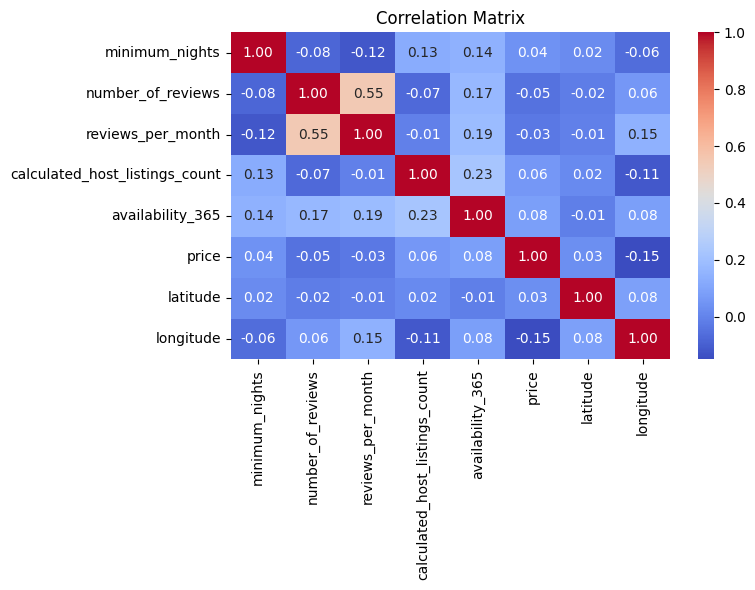

In [ ]:
correlation_matrix = df[['minimum_nights', 'number_of_reviews', 'reviews_per_month',
                       'calculated_host_listings_count','availability_365', 'price', 'latitude', 'longitude']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

The correlation matrix suggests that there is no strong correlation between any numerical features and rental prices.

Note (after mid-project presentation): Change price to log price and see correlation matrix. And, add scatterplots instead of line graphs.

# Visualising non-numerical relationships



In [ ]:
qualitative_columns = df.select_dtypes(exclude=['number']).columns
 # Handle missing values if needed

# Convert qualitative data to numerical representation using ordinal encoding
encoder = OrdinalEncoder()
df[qualitative_columns] = encoder.fit_transform(df[qualitative_columns])
print(df)

             id     name   host_id  host_name  neighbourhood_group  \
0          2539  12328.0      2787     4989.0                  1.0   
1          2595  37455.0      2845     4785.0                  2.0   
2          3647  43543.0      4632     2909.0                  2.0   
3          3831  14783.0      4869     6203.0                  1.0   
4          5022  18693.0      7192     5923.0                  2.0   
...         ...      ...       ...        ...                  ...   
48890  36484665  11647.0   8232441     9051.0                  1.0   
48891  36485057   3520.0   6570630     6776.0                  1.0   
48892  36485431  42464.0  23492952     4263.0                  2.0   
48893  36485609   2572.0  30985759    10190.0                  2.0   
48894  36487245  44538.0  68119814     1968.0                  2.0   

       neighbourhood  latitude  longitude  room_type  price  minimum_nights  \
0              108.0  40.64749  -73.97237        1.0    149               1   
1

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix')

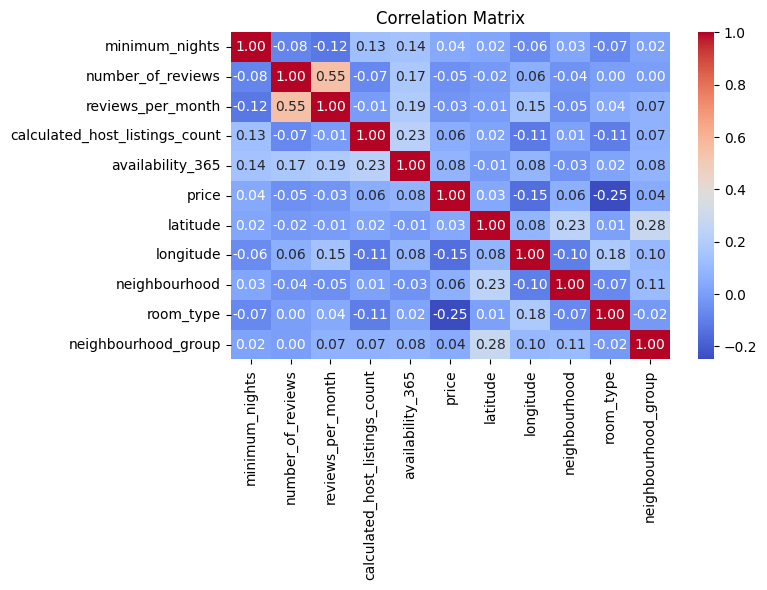

In [ ]:
correlation_matrix = df[['minimum_nights', 'number_of_reviews', 'reviews_per_month',
                       'calculated_host_listings_count','availability_365', 'price', 'latitude', 'longitude','neighbourhood','room_type','neighbourhood_group']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [ ]:
# Separate numerical and categorical columns
numeric_columns = df.select_dtypes(include=['number']).columns
categorical_columns = df.select_dtypes(exclude=['number']).columns

# Handle missing values for numerical columns
imputer = SimpleImputer(strategy='mean')
df_numeric_imputed = pd.DataFrame(imputer.fit_transform(df[numeric_columns]), columns=numeric_columns)
df_imputed = pd.concat([df_numeric_imputed, df[categorical_columns]], axis=1)
encoder = OrdinalEncoder()
encoded_data = encoder.fit_transform(df_imputed)
log_encoded_data = np.log(encoded_data + 1)  # Adding 1 to avoid log(0)
X = log_encoded_data[:, :-1]  # Features
y = log_encoded_data[:, -1]   # Target
threshold = np.mean(y)
binary_labels = (y > threshold).astype(int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, binary_labels, test_size=0.2, random_state=35)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)
# Predict on the testing set
y_pred = model.predict(X_test)
feature_range=(min, max)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Accuracy: 0.7725738828101033


<Figure size 800x600 with 0 Axes>

<Axes: >

NameError: name 'plot_roc_curve' is not defined

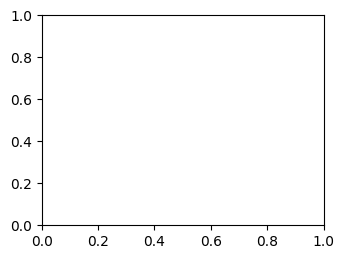

In [ ]:
# Fit the model
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
plot_roc_curve(model, X_test, y_test)
plt.title('ROC Curve')

# Plot Precision-Recall curve
plt.subplot(2, 2, 2)
plot_precision_recall_curve(model, X_test, y_test)
plt.title('Precision-Recall Curve')

# Plot Confusion Matrix
plt.subplot(2, 2, 3)
plot_confusion_matrix(model, X_test, y_test)
plt.title('Confusion Matrix')

# Plot Learning Curve
plt.subplot(2, 2, 4)
plot_learning_curve(model, X_train, y_train)
plt.title('Learning Curve')

plt.tight_layout()
plt.show()


fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()


precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Predicted Negative', 'Predicted Positive'])
plt.yticks([0, 1], ['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')


train_sizes, train_scores, test_scores = learning_curve(
model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])

# Example usage
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Load dataset
data = load_iris()
X = data.data
y = data.target

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize model
model = RandomForestClassifier()

# Plot model performance
plot_model_performance(model, X_train, y_train, X_test, y_test)


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='availability_365', ylabel='reviews_per_month'>

Text(0.5, 1.0, 'Relationship between Availability and Reviews per month')

Text(0.5, 0, 'Availability')

Text(0, 0.5, 'Mean reviews per month')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

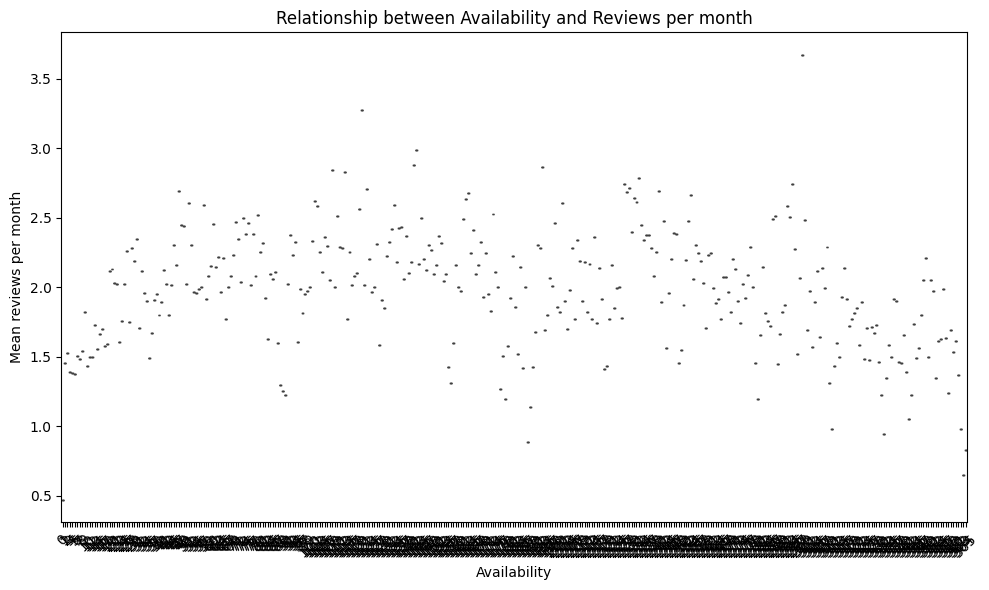

In [ ]:
plt.figure(figsize=(10, 6))
mean_reviews_per_month = df.groupby('availability_365')['reviews_per_month'].mean().reset_index()
sns.boxplot(data=mean_reviews_per_month, x='availability_365', y='reviews_per_month') # corrected Avalibility to Availability
plt.title('Relationship between Availability and Reviews per month')
plt.xlabel('Availability')
plt.ylabel('Mean reviews per month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()